In [2]:
def recall_at_k(relevant_ids, retrieved_ids, k):
    return int(any(doc_id in retrieved_ids[:k] for doc_id in relevant_ids))


def precision_at_k(relevant_ids, retrieved_ids, k):
    if k == 0:
        return 0.0
    hits = sum(1 for doc_id in retrieved_ids[:k] if doc_id in relevant_ids)
    return hits / k


def mrr(relevant_ids, retrieved_ids):
    for i, doc_id in enumerate(retrieved_ids, start=1):
        if doc_id in relevant_ids:
            return 1.0 / i
    return 0.0

In [13]:
import json
from pathlib import Path

# --------------------
# Helper function to get latest file by pattern
# --------------------
def get_latest_file(folder: Path, pattern: str) -> Path:
    files = list(folder.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files found matching {pattern} in {folder}")
    # Pick the file with the latest timestamp in filename
    # Assumes filenames have format like 'dense_eval_YYYYMMDDTHHMMSS.json'
    return max(files, key=lambda f: f.stem.split("_")[-1])

# --------------------
# Folders
# --------------------
eval_folder = Path("../data/eval/results")
ground_truth_folder = Path("../data/eval")

# --------------------
# Load latest evaluation files
# --------------------
dense_file = get_latest_file(eval_folder, "dense_eval_*.json")
sparse_file = get_latest_file(eval_folder, "sparse_eval_*.json")
hybrid_file = get_latest_file(eval_folder, "hybrid_eval_*.json")

with open(dense_file, "r") as f:
    dense_eval = json.load(f)
with open(sparse_file, "r") as f:
    sparse_eval = json.load(f)
with open(hybrid_file, "r") as f:
    hybrid_eval = json.load(f)

print(f"Loaded {len(dense_eval)} dense queries from {dense_file.name}")
print(f"Loaded {len(sparse_eval)} sparse queries from {sparse_file.name}")
print(f"Loaded {len(hybrid_eval)} hybrid queries from {hybrid_file.name}")

Loaded 15 dense queries from dense_eval_20260125T151933.json
Loaded 15 sparse queries from sparse_eval_20260125T151925.json
Loaded 15 hybrid queries from hybrid_eval_20260125T151944.json


In [14]:
from pathlib import Path
import json

eval_folder = Path("../data/eval/results")

# Latest hybrid eval
hybrid_file = get_latest_file(eval_folder, "hybrid_eval_*.json")
with open(hybrid_file) as f:
    hybrid_eval = json.load(f)

# Reranked output
reranked_file = eval_folder / "reranked_crossencoder.json"
with open(reranked_file) as f:
    reranked_eval = json.load(f)

print(f"Hybrid eval: {hybrid_file.name}")
print(f"Reranked eval: {reranked_file.name}")


Hybrid eval: hybrid_eval_20260125T151944.json
Reranked eval: reranked_crossencoder.json


In [15]:
# Map reranked results by query
reranked_by_query = {
    item["query"]: [doc["id"] for doc in item["reranked_docs"]]
    for item in reranked_eval
}


In [16]:
RERANK_K = 10

reranked_metrics = []

for item in hybrid_eval:
    query = item["query"]
    relevant_ids = item["relevant_doc_ids"]

    if query not in reranked_by_query:
        continue

    reranked_ids = reranked_by_query[query]

    reranked_metrics.append({
        "query": query,
        "method": "Hybrid + CrossEncoder",
        "recall_at_k": recall_at_k(relevant_ids, reranked_ids, RERANK_K),
        "mrr": mrr(relevant_ids, reranked_ids),
        "precision_at_k": precision_at_k(relevant_ids, reranked_ids, RERANK_K),
    })


In [17]:
import pandas as pd

df_hybrid = pd.DataFrame(hybrid_eval)
df_hybrid["method"] = "Hybrid"

df_reranked = pd.DataFrame(reranked_metrics)

metrics = ["recall_at_k", "mrr", "precision_at_k"]

df_all = pd.concat(
    [df_hybrid[["query", "method"] + metrics], df_reranked],
    ignore_index=True
)

df_all


,query,method,recall_at_k,mrr,precision_at_k
0,differences between Gemini developer API featu...,Hybrid,0,0.000000,0.0
1,how to integrate Gemini API for building AI ap...,Hybrid,0,0.000000,0.0
2,what is Gemini model family and how do I use i...,Hybrid,1,1.000000,0.2
3,how do Gemini embeddings work for semantic sea...,Hybrid,1,1.000000,0.2
4,how to run Gemini Nano on Android devices for ...,Hybrid,1,0.500000,0.2
5,what are the different Gemini AI models and wh...,Hybrid,0,0.000000,0.0
6,how does the Gemini 2.5 series compare to olde...,Hybrid,1,1.000000,0.2
7,what are the best Gemini models right now for ...,Hybrid,1,1.000000,0.2
8,where can I test AI models with LMArena and se...,Hybrid,1,0.500000,0.2
9,how do Gemini models perform on coding and mul...,Hybrid,0,0.000000,0.0


In [18]:
avg_metrics = df_all.groupby("method")[metrics].mean().reset_index()
avg_metrics


,method,recall_at_k,mrr,precision_at_k
0,Hybrid,0.733333,0.633333,0.146667
1,Hybrid + CrossEncoder,0.733333,0.550000,0.073333


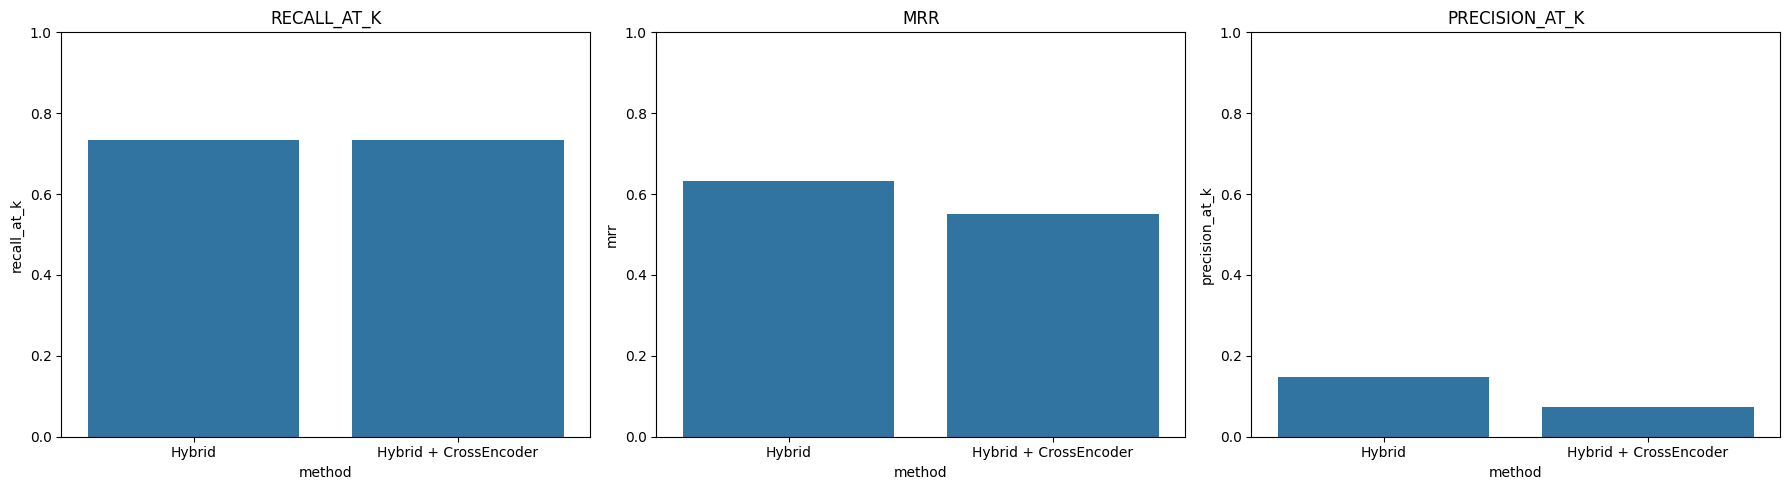

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, metric in enumerate(metrics):
    sns.barplot(data=avg_metrics, x="method", y=metric, ax=axes[i])
    axes[i].set_title(metric.upper())
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()


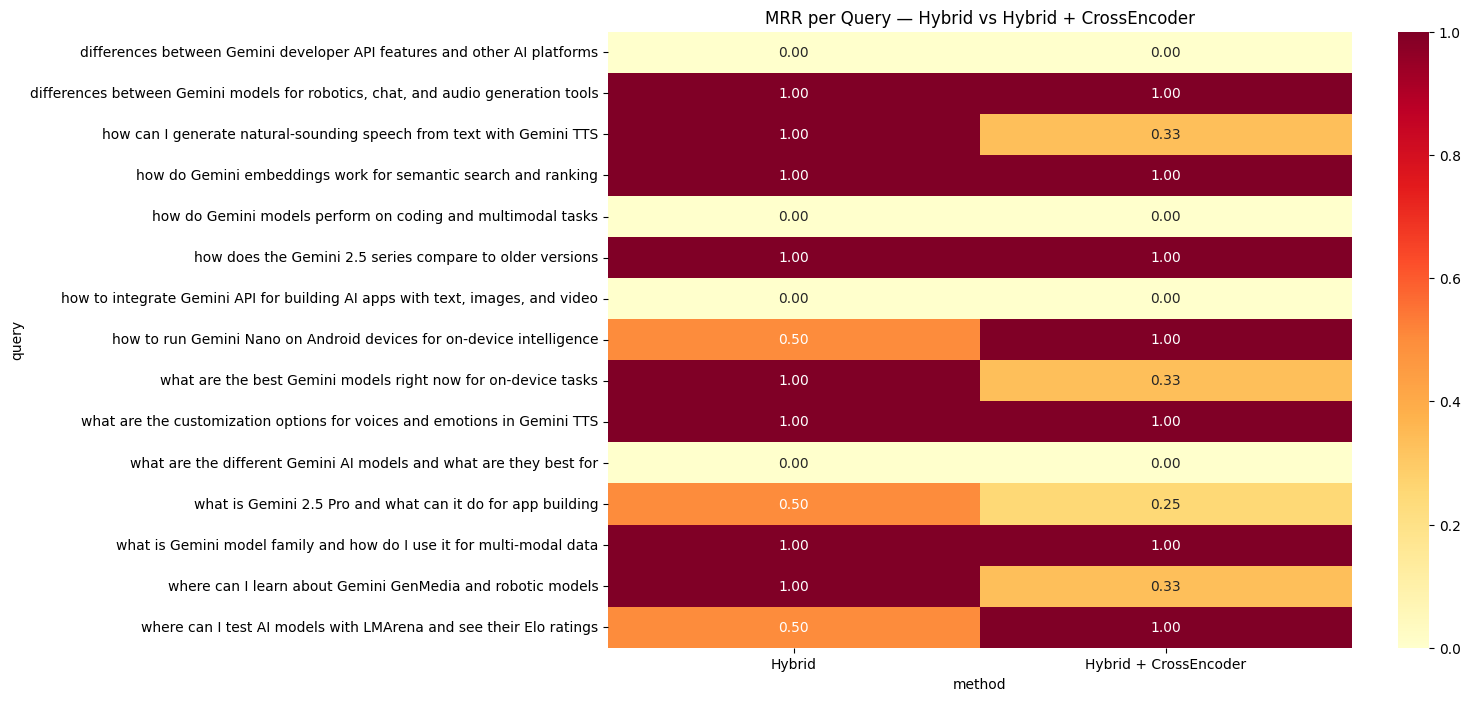

In [20]:
pivot = df_all.pivot(index="query", columns="method", values="mrr")

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("MRR per Query — Hybrid vs Hybrid + CrossEncoder")
plt.show()


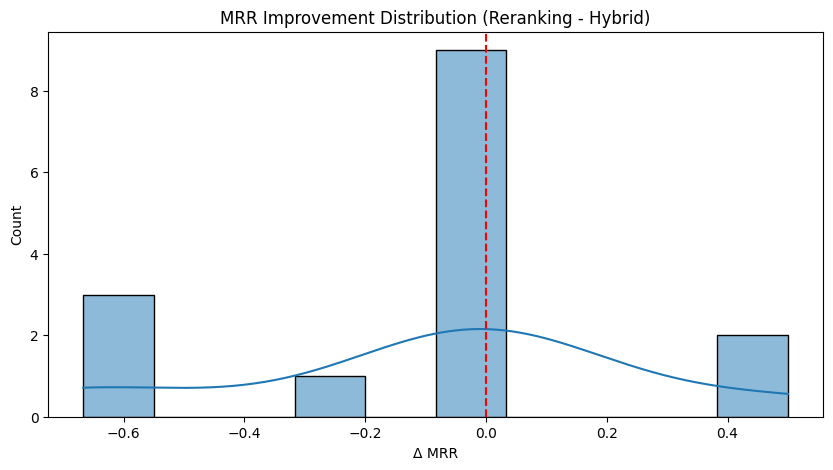

Queries improved: 2
Queries worsened: 4
Unchanged: 9


In [21]:
delta = pivot["Hybrid + CrossEncoder"] - pivot["Hybrid"]

plt.figure(figsize=(10,5))
sns.histplot(delta, bins=10, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("MRR Improvement Distribution (Reranking - Hybrid)")
plt.xlabel("Δ MRR")
plt.show()

print(f"Queries improved: {(delta > 0).sum()}")
print(f"Queries worsened: {(delta < 0).sum()}")
print(f"Unchanged: {(delta == 0).sum()}")
